# Implementation Details
The models of the discriminator and generator are inspired from [here](https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html). The different hyperparameter values and the idea of explicit random weight initialization from a normal distribution with mean 0 and standard deviation 0.02 are taken from this [DCGAN Paper](https://arxiv.org/abs/1511.06434).

# Defining Accelerator

In [1]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import random
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as dataset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import torch.optim as optim
import torch.utils as utils

# Input data files are available in the read-only "../input/" directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

# Input data files are available in the read-only "../input/" directory
# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Loading Training Data

In [3]:
image_size = 64
transform = transforms.Compose([transforms.Resize(image_size), transforms.CenterCrop(image_size), transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
IMAGE_PATH = '../input/celeba-dataset/img_align_celeba/'

dset = dataset.ImageFolder(root = IMAGE_PATH, transform = transform)
dataloader = utils.data.DataLoader(dset, batch_size = 128, shuffle = True, num_workers = 2, drop_last = True)

# Visualizing the Data

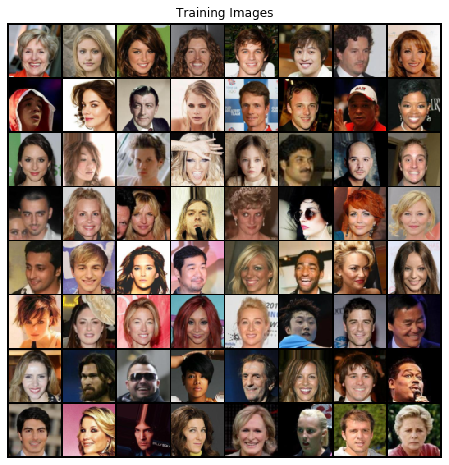

In [4]:
real_batch = next(iter(dataloader))
plt.figure(figsize = (8, 8))
plt.axis('off')
plt.title('Training Images')
plt.imshow(np.transpose((vutils.make_grid(real_batch[0].to(device)[:64], padding = 2, normalize = True)).cpu().numpy(), (1, 2, 0)))

# Random Weight Initialization

In [5]:
def weight_init(instance):
    classname = instance.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(instance.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(instance.weight.data, 0.0, 0.02)
        nn.init.constant_(instance.bias.data, 0.0)

# Discriminator Model

In [6]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size = 4, stride = 2, padding = 1, bias = False)
        self.conv2 = nn.Conv2d(64, 128, kernel_size = 4, stride = 2, padding = 1, bias = False)
        self.conv2_bn = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size = 4, stride = 2, padding = 1, bias = False)
        self.conv3_bn = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 512, kernel_size = 4, stride = 2, padding = 1, bias = False)
        self.conv4_bn = nn.BatchNorm2d(512)
        self.conv5 = nn.Conv2d(512, 1, kernel_size = 4, stride = 1, padding = 0, bias = False)
        
    def forward(self, x):
        x = x.view(-1, 3, 64, 64)
        x = F.leaky_relu(self.conv1(x), 0.2, inplace = True)
        x = self.conv2(x)
        x = F.leaky_relu(self.conv2_bn(x), 0.2, inplace = True)
        x = self.conv3(x)
        x = F.leaky_relu(self.conv3_bn(x), 0.2, inplace = True)
        x = self.conv4(x)
        x = F.leaky_relu(self.conv4_bn(x), 0.2, inplace = True)
        x = self.conv5(x)
        x = F.sigmoid(x)
        out = x.view(-1, 1)
        
        return out        

# Generator Model

In [7]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_transpose1 = nn.ConvTranspose2d(100, 512, kernel_size = 4, stride = 1, padding = 0, bias = False)
        self.conv_transpose1_bn = nn.BatchNorm2d(512)
        self.conv_transpose2 = nn.ConvTranspose2d(512, 256, kernel_size = 4, stride = 2, padding = 1, bias = False)
        self.conv_transpose2_bn = nn.BatchNorm2d(256)
        self.conv_transpose3 = nn.ConvTranspose2d(256, 128, kernel_size = 4, stride = 2, padding = 1, bias = False)
        self.conv_transpose3_bn = nn.BatchNorm2d(128)
        self.conv_transpose4 = nn.ConvTranspose2d(128, 64, kernel_size = 4, stride = 2, padding = 1, bias = False)
        self.conv_transpose4_bn = nn.BatchNorm2d(64)
        self.conv_transpose5 = nn.ConvTranspose2d(64, 3, kernel_size = 4, stride = 2, padding = 1, bias = False)
    
    def forward(self, x):
        x = x.view(-1, 100, 1, 1)
        x = self.conv_transpose1(x)
        x = F.relu(self.conv_transpose1_bn(x), inplace = True)
        x = self.conv_transpose2(x)
        x = F.relu(self.conv_transpose2_bn(x), inplace = True)
        x = self.conv_transpose3(x)
        x = F.relu(self.conv_transpose3_bn(x), inplace = True)
        x = self.conv_transpose4(x)
        x = F.relu(self.conv_transpose4_bn(x), inplace = True)
        x = self.conv_transpose5(x)
        out = torch.tanh(x)
        
        return out   

# Creating Model Instances

In [8]:
D = Discriminator()
D = D.to(device)
D = D.float()
D.apply(weight_init)
print(D)

G = Generator()
G = G.to(device)
G = G.float()
G.apply(weight_init)
print(G)

Discriminator(
  (conv1): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (conv2_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (conv3_bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (conv4_bn): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
)
Generator(
  (conv_transpose1): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (conv_transpose1_bn): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_transpose2): ConvTranspose2d(512, 256, kernel_s

# Defining Losses

In [9]:
loss = nn.BCELoss()
def real_loss_fn(real_out):
    labels = torch.ones(real_out.size()[0], 1).to(device)
    loss_real = loss(real_out.squeeze(), labels.squeeze())
    return loss_real

def fake_loss_fn(fake_out):
    labels = torch.zeros(fake_out.size()[0], 1).to(device)
    loss_fake = loss(fake_out.squeeze(), labels.squeeze())
    return loss_fake

# Defining Optimizers

In [10]:
disc_opt = optim.Adam(D.parameters(), lr = 0.0002, betas = (0.5, 0.999))
gen_opt = optim.Adam(G.parameters(), lr = 0.0002, betas = (0.5, 0.999)) 

In [11]:
def train(D, G, dataloader, disc_opt, gen_opt, num_epochs, fac, batch_size = 128):
    
    disc_losses = []
    gen_losses = []
    
    fixed_noise = torch.randn(64, 100).to(device)
    
    D.train()
    G.train()
    
    for epoch in range(num_epochs + 1):
        
        gen_loss_total = 0
        disc_loss_total = 0
        
        for i, data in enumerate(dataloader, 0):
            disc_opt.zero_grad()
            
            x = data[0].to(device)
            real_out = D(x.float())
            real_loss = real_loss_fn(real_out)
            
            gen_in1 = torch.randn(batch_size, 100).to(device)
            disc_gen_in1 = G(gen_in1.float()).detach()
            fake_out = D(disc_gen_in1.float())
            fake_loss = fake_loss_fn(fake_out)
            
            disc_loss = real_loss + fake_loss
            disc_loss_total += disc_loss
            
            disc_loss.backward()
            disc_opt.step()
            
            gen_opt.zero_grad()
            
            gen_in2 = torch.randn(batch_size, 100).to(device)
            disc_gen_in2 = G(gen_in2.float())
            real_fake_out = D(disc_gen_in2.float())
            gen_loss = real_loss_fn(real_fake_out)
            gen_loss_total += gen_loss
            
            gen_loss.backward()
            gen_opt.step()
            
        disc_losses.append(disc_loss_total)
        gen_losses.append(gen_loss_total)
        print("Epoch ", epoch, " - ", "Discriminator Loss: ", disc_loss_total/len(dataloader), " Generator Loss: ", gen_loss_total/len(dataloader))
        
        if epoch % fac == 0:
            G.eval()
            sample_out = G(fixed_noise.float())
            G.train()
            
            plt.figure(figsize = (8,8))
            plt.axis('off')
            
            sample_out = vutils.make_grid(sample_out, padding = 2, normalize = True).cpu().detach().numpy()
            sample_out = np.transpose(sample_out, (1, 2, 0))
            plt.imshow(sample_out)
            
    return disc_losses, gen_losses            

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch  0  -  Discriminator Loss:  tensor(0.6411, device='cuda:0', grad_fn=<DivBackward0>)  Generator Loss:  tensor(3.1960, device='cuda:0', grad_fn=<DivBackward0>)
Epoch  1  -  Discriminator Loss:  tensor(0.7023, device='cuda:0', grad_fn=<DivBackward0>)  Generator Loss:  tensor(2.9311, device='cuda:0', grad_fn=<DivBackward0>)
Epoch  2  -  Discriminator Loss:  tensor(0.7419, device='cuda:0', grad_fn=<DivBackward0>)  Generator Loss:  tensor(2.3497, device='cuda:0', grad_fn=<DivBackward0>)
Epoch  3  -  Discriminator Loss:  tensor(0.7655, device='cuda:0', grad_fn=<DivBackward0>)  Generator Loss:  tensor(2.1723, device='cuda:0', grad_fn=<DivBackward0>)
Epoch  4  -  Discriminator Loss:  tensor(0.7521, device='cuda:0', grad_fn=<DivBackward0>)  Generator Loss:  tensor(2.1248, device='cuda:0', grad_fn=<DivBackward0>)
Epoch  5  -  Discriminator Loss:  tensor(0.7238, device='cuda:0', grad_fn=<DivBackward0>)  Generator Loss:  tensor(2.2077, device='cuda:0', grad_fn=<DivBackward0>)


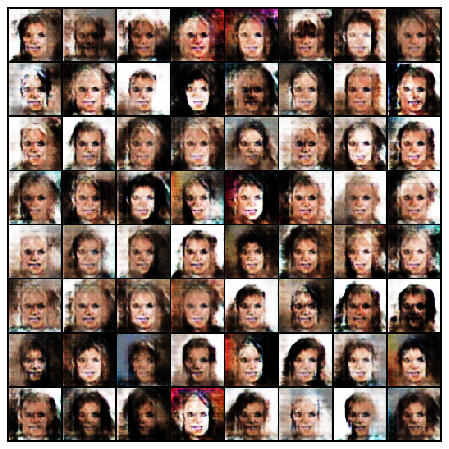

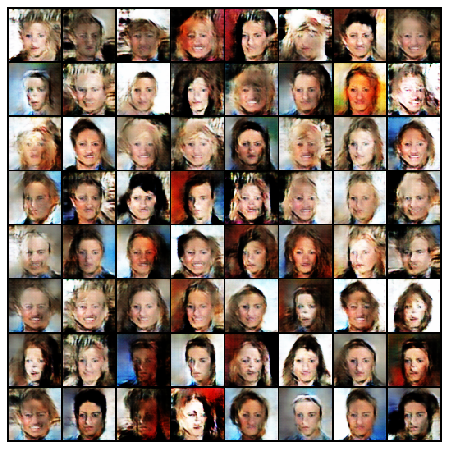

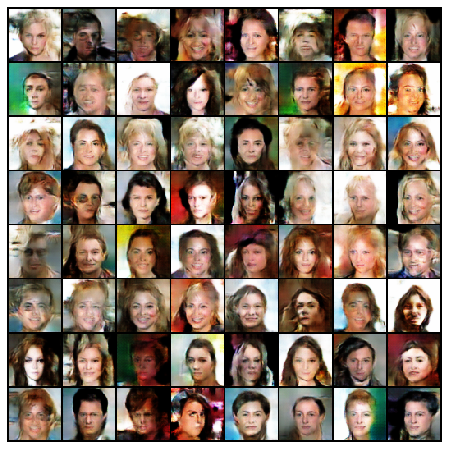

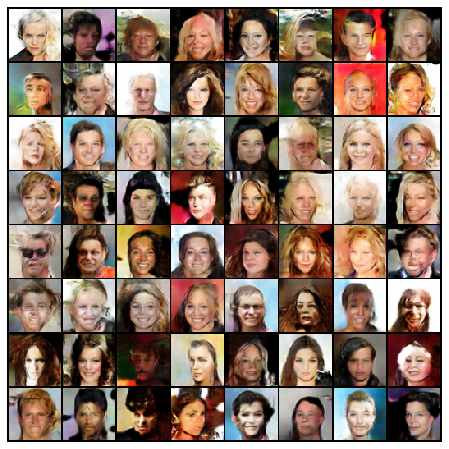

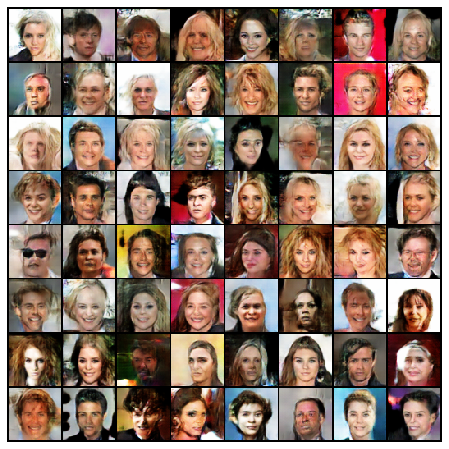

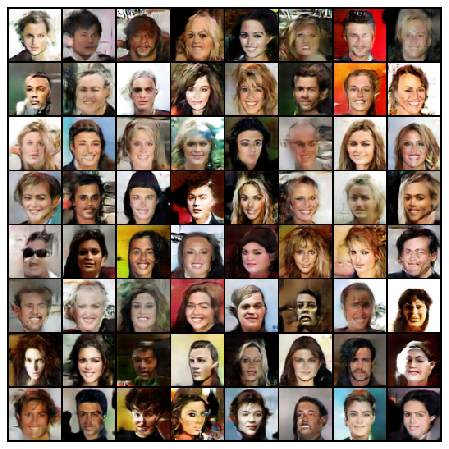

In [12]:
disc_losses, gen_losses = train(D, G, dataloader, disc_opt, gen_opt, 5, 1)

# Plotting Losses

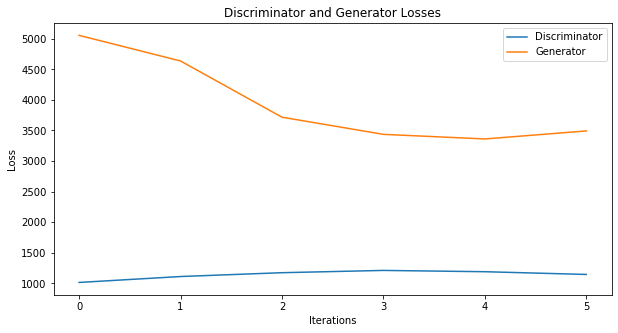

In [13]:
disc_losses = np.array(disc_losses)
gen_losses = np.array(gen_losses)
plt.figure(figsize = (10, 5))
plt.title('Discriminator and Generator Losses')
plt.plot(disc_losses, label = 'Discriminator')
plt.plot(gen_losses, label = 'Generator')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()